# Wasserstein GAN with Gradient Penalty (WGAN-GP)

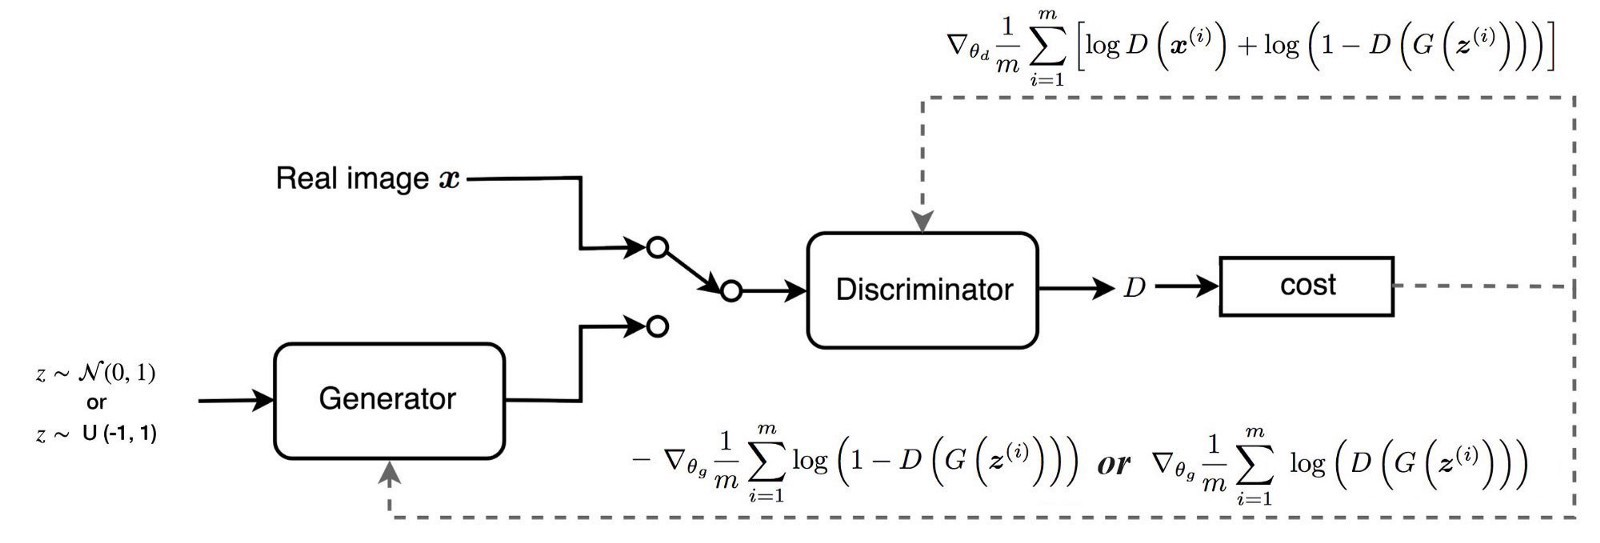

### Wasserstein GAN with Gradient Penalty (WGAN-GP) solves following issues<br>  - stability 
### - gradient penalties to prevent mode collapse.

In [1]:
# importing required packages
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

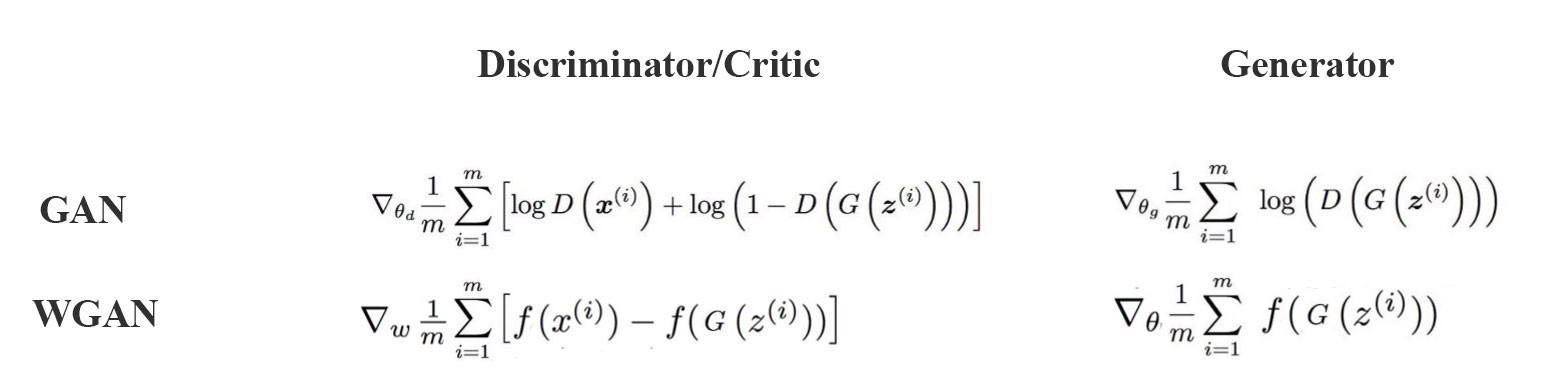

## Generator
### Building a generator having 6 layers.

In [2]:
# Generator (for generating fake images)

class Generator(nn.Module):
  
    # z_dim : noise vector dimension
    # output_channel : tnumber of channels of the output image, it is 1 for MNIST(black and white) dataset.
    # hidden_dimension : inner dimension of the generator model

    def __init__(self, z_dimension=10, output_channel=1, hidden_dimension=64):
        super(Generator, self).__init__()

        self.z_dimension = z_dimension

        # Building the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dimension, hidden_dimension * 2),
            self.make_gen_block(hidden_dimension * 2, hidden_dimension * 4),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 8, stride=1),
            self.make_gen_block(hidden_dimension * 8, hidden_dimension * 4, stride=1),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 2, stride=1),
            self.make_gen_block(hidden_dimension * 2, output_channel, kernel_size=4, final_layer=True),
        )


    # building neural block
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channel
        # output_channels : number of output channel
        # kernel_size : size of convolutional filter
        # stride : stride of the convolution
        # final_layer : boolean value, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

        # Final Layer
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
  
    # Function for completing a forward pass of the generator: Given a noise tensor, returns generated images.
    def forward(self, noise):
        
        # noise: a noise tensor with dimensions (n_samples, z_dimension)
        

        # a noise with width = 1, height = 1, number of channels = z_dimension, number of samples = len(noise)
        x = noise.view(len(noise), self.z_dimension, 1, 1)
        return self.gen(x)


    # Function for creating noise vectors: Given the dimensions (n_samples, z_dim) creates a tensor of that shape filled with random numbers 
    # from the normal distribution
    def get_noise(self, n_samples, device='cpu'):
    
        # n_samples: the number of samples to generate, a scalar
        # z_dimension: the dimension of the noise vector, a scalar
        # device: the device type (cpu / cuda)
    
        return torch.randn(n_samples, self.z_dimension, device=device)

## Critic

In [3]:
# Critic

class Critic(nn.Module):

    # im_chan :  number of output channel (1 channel for MNIST dataset which has balck and white image)
    # hidden_dim : number of inner channel

    def __init__(self, im_chan=1, hidden_dim=32):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim * 2, stride=1),
            self.make_crit_block(hidden_dim * 2, hidden_dim * 4),
            self.make_crit_block(hidden_dim * 4, hidden_dim * 2),

            self.make_crit_block(hidden_dim * 2, 1, kernel_size=4, final_layer=True),
        )


    # Build the neural block
    def make_crit_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channels
        # output_channels : number of output channels
        # kernel_size : the size of each convolutional filter
        # stride : the stride of the convolution
        # final_layer : a boolean, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    # Function for completing a forward pass of the Critic: Given an image tensor, returns a 1-dimension tensor representing fake/real.
    def forward(self, image):
        # image: a flattened image tensor 
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Parameters

In [4]:
# weight of the gradient penalty to maintain 1-Lipschitz Continuity
c_lambda = 10

# number of times to update the critic per generator update
crit_repeats = 3

# dimension of the noise vector
z_dim = 64

# ow often to display/visualize the images
display_step = 1000

# number of images per forward/backward pass
batch_size = 128

# the learning rate
lr = 0.0002

#the device type 
device = 'cuda'

# the momentum term
beta_1 = 0.5 
beta_2 = 0.999

# the number of times you iterate through the entire dataset when training
n_epochs = 100

## Downloading dataset

In [5]:
# # You can tranform the image values to be between -1 and 1 (the range of the tanh activation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### initializing generator, critic, and optimizers.

In [6]:
# generator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

# critic
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

### initializing the generator and discriminator weights to the normal distribution with mean 0 and standard deviation 0.02

In [7]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty
### 1. compute gradient with respect to the mixed images
###    a. create a mixed image by weighing the fake and real image using epsilon and then adding them together. 
###    b.  get the critic's output on the mixed image<br><br>
### 2. compute gradient penalty given the gradient
###    a. magnitude of each image gradient
###    b. calculate the penalty 

In [8]:
# compute gradient with respect to the mixed images

def get_gradient(crit, real, fake, epsilon):
    
    
        # crit: the critic model
        # real: a batch of real images
        # fake: a batch of fake images
        # epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,

        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]

    # Return the gradient of the critic's scores with respect to mixes of real and fake images.
    return gradient

In [9]:
# compute gradient penalty given the gradient

def gradient_penalty(gradient):
    
    #gradient: the gradient of the critic's scores, with respect to the mixed image

    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####

    # returns the gradient penalty
    return penalty

## Generator loss

In [10]:
def get_gen_loss(crit_fake_pred):
    
    gen_loss = -1. * torch.mean(crit_fake_pred)

    # a scalar loss value
    return gen_loss

## Critic loss

In [11]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    
   
        #crit_fake_pred: the critic's scores of the fake images
        #crit_real_pred: the critic's scores of the real images
        #gp: the unweighted gradient penalty
        #c_lambda: the current weight of the gradient penalty 
    
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    # a scalar for the critic's loss
    return crit_loss

## Output Visualisation

In [12]:
def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28)):

    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 13.141155301328865, critic loss: -85.57313908147563


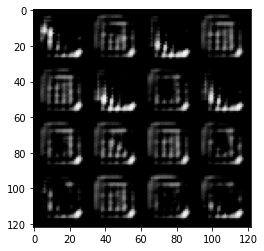

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


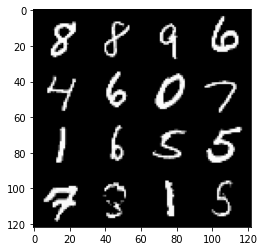

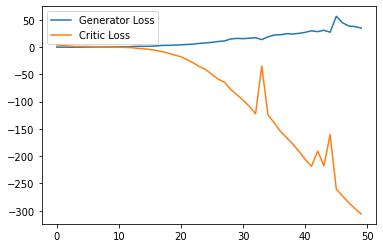

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 68.58065679907799, critic loss: -704.122928295453


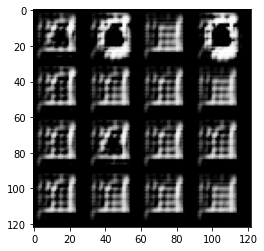

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


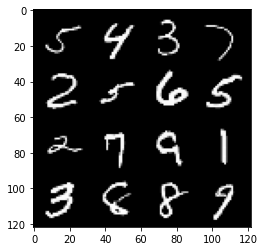

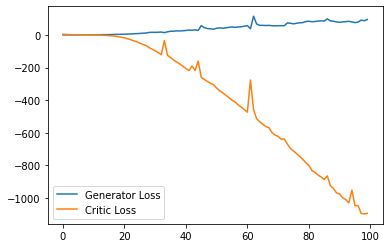

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 116.39763009262084, critic loss: -1122.141077463786


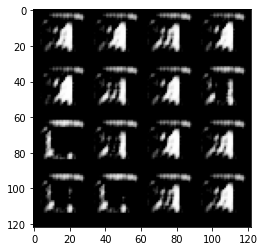

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


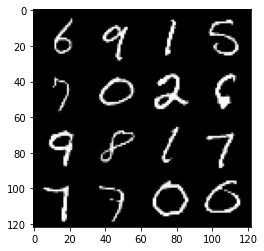

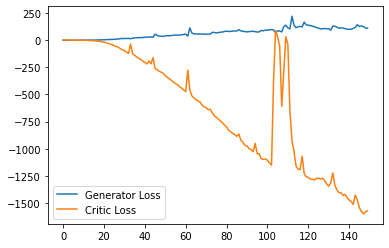

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 121.40621089410782, critic loss: -154.7692601782482


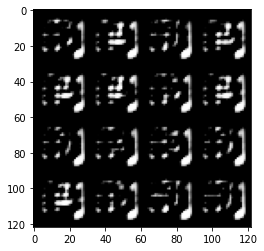

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


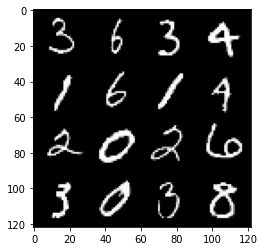

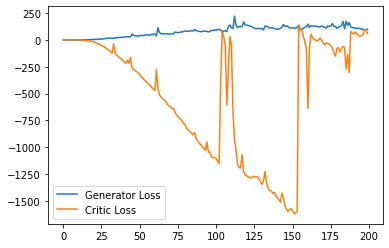

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 142.7028359940052, critic loss: -279.10389977200816


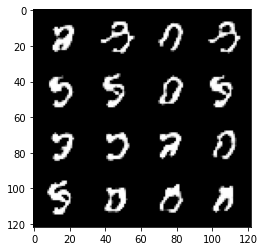

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


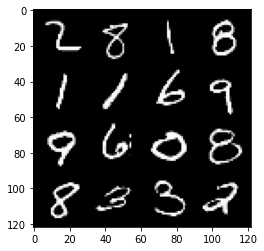

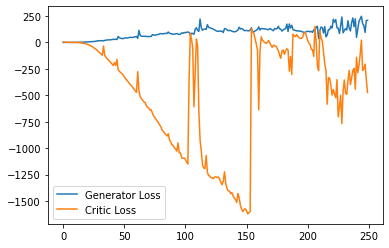

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 143.06562612962722, critic loss: 26.91176336860659


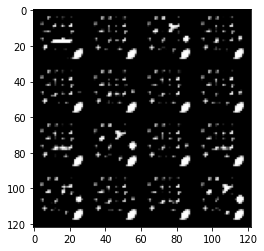

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


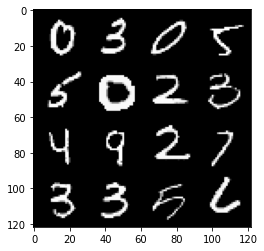

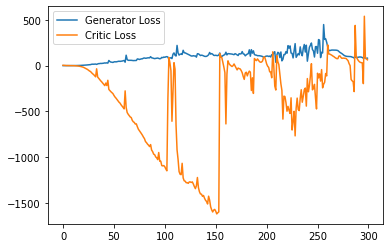

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 98.44883974456788, critic loss: -678.621711920421


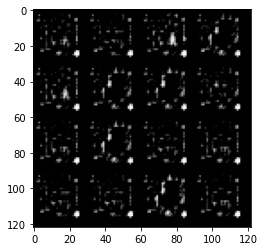

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


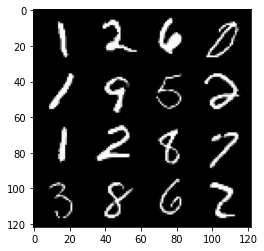

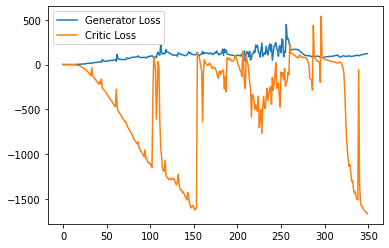

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 156.41500447082518, critic loss: -575.6232035659157


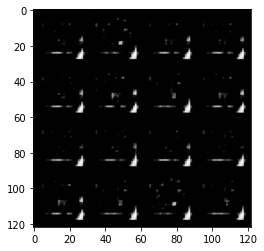

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


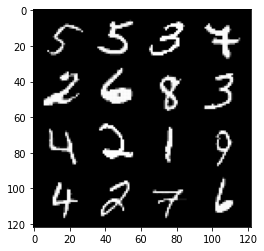

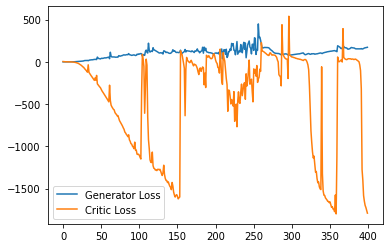

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 204.5450421562195, critic loss: -212.53370019690192


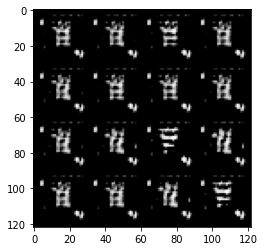

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


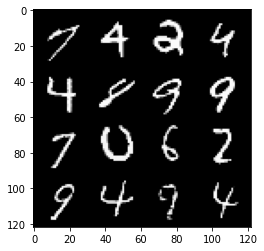

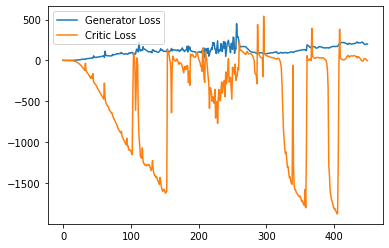

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: 215.83493076753615, critic loss: -658.3275974857006


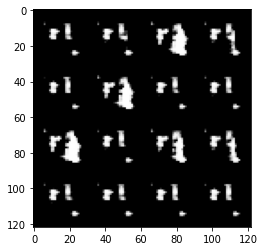

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


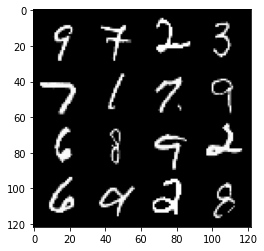

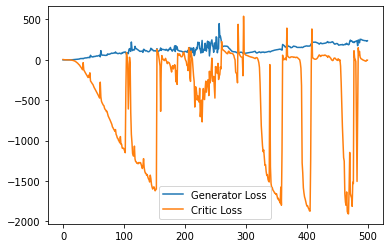

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: 242.98816647338867, critic loss: -4.272860135316849


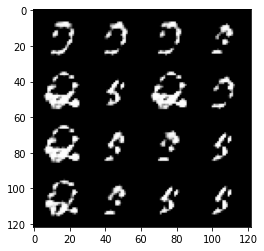

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


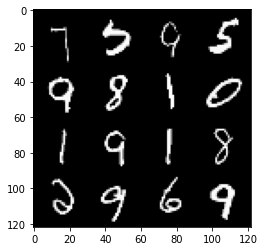

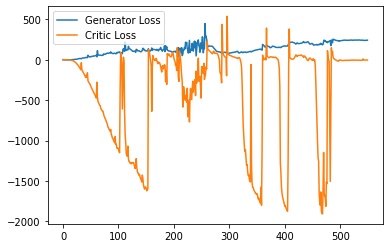

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: 243.40539518737793, critic loss: -1.1519284543593722


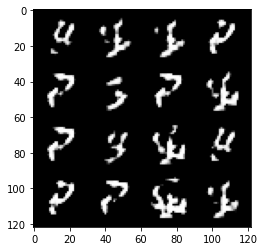

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


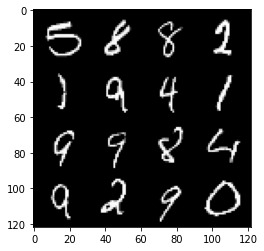

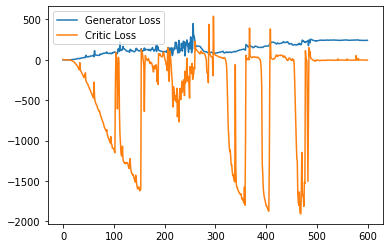

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: 240.40927708435058, critic loss: -0.6719319317837557


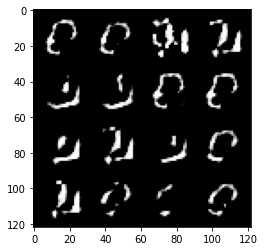

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


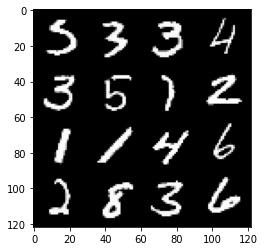

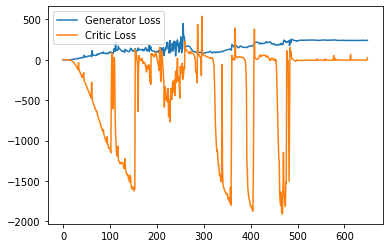

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: 238.72788790893554, critic loss: -0.33186090806374946


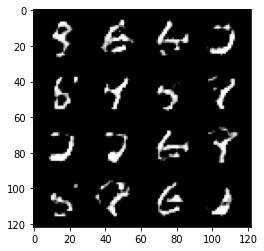

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


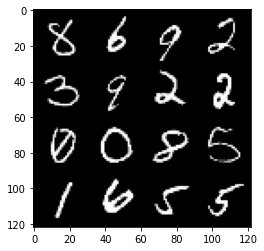

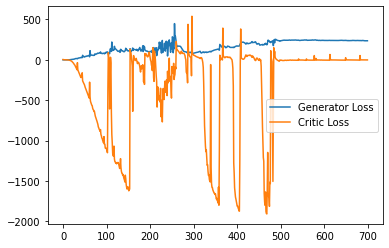

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: 236.5919867401123, critic loss: -0.2909749417056654


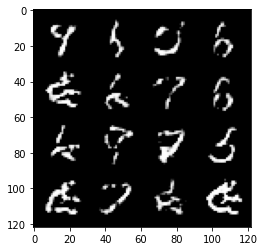

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


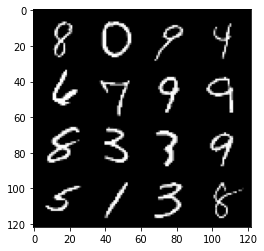

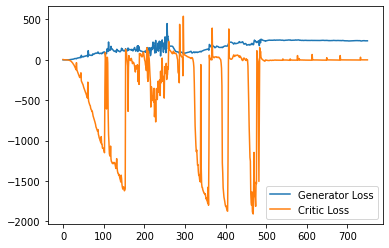

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: 234.19407092285155, critic loss: -0.40863916449993865


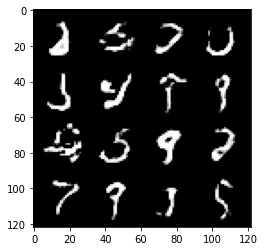

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


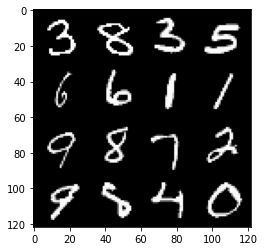

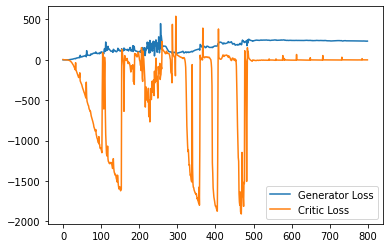

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: 230.34810319519042, critic loss: -0.7822895183463894


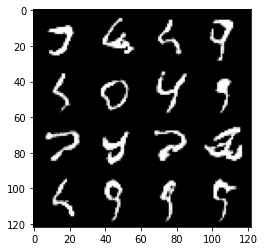

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


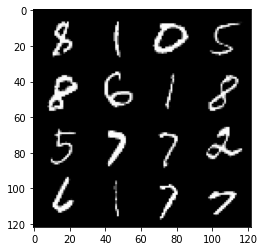

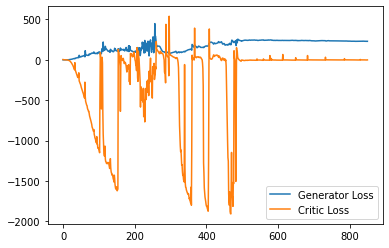

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: 229.88309342956543, critic loss: -0.9285477717022097


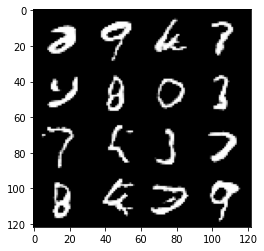

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


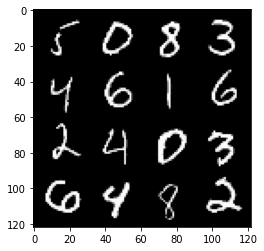

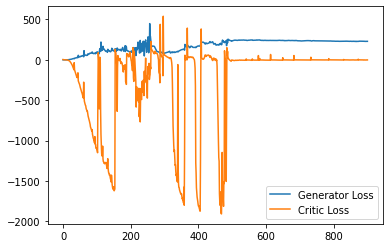

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: 229.70676539611816, critic loss: -0.7539073813632123


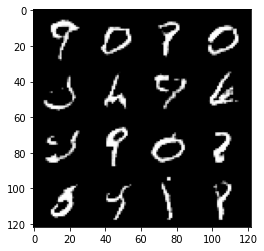

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


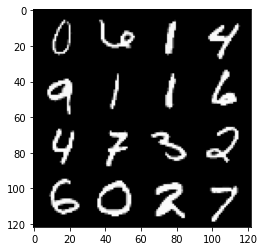

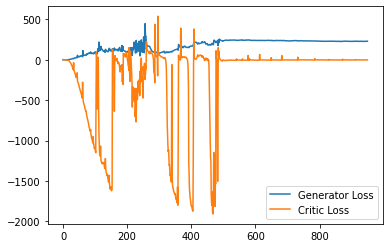

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20000: Generator loss: 229.49521241760254, critic loss: -0.5740137297362093


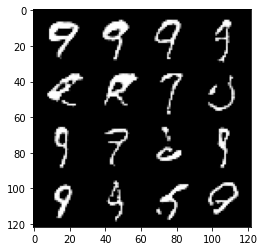

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


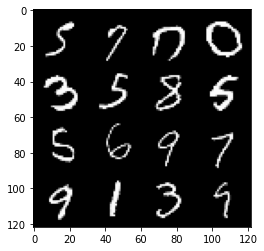

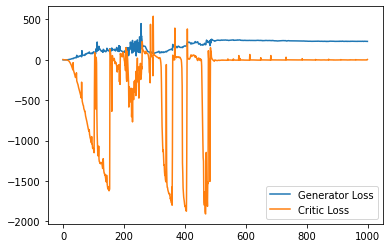

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 21000: Generator loss: 228.82125805664063, critic loss: -0.5167204422454034


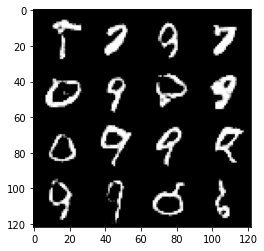

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


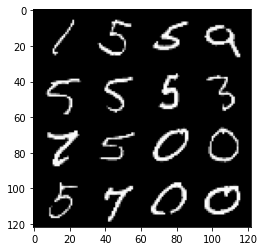

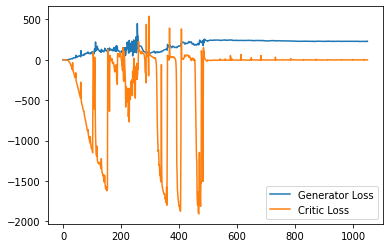

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 22000: Generator loss: 229.00047468566893, critic loss: -0.5114406110073128


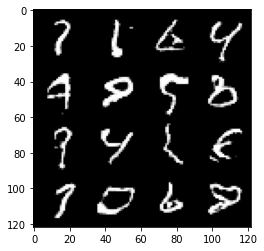

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


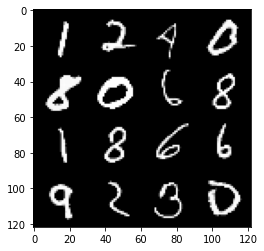

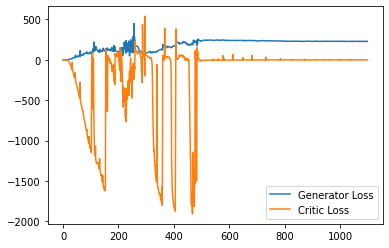

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 23000: Generator loss: 228.76314112854004, critic loss: -0.5573334825510782


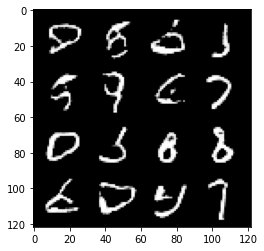

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


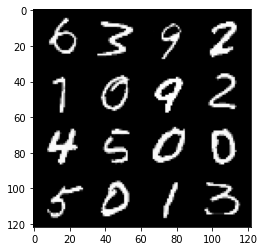

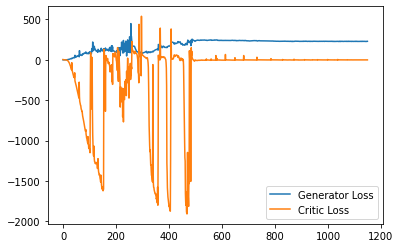

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 24000: Generator loss: 228.41955035400392, critic loss: -0.6534539982018366


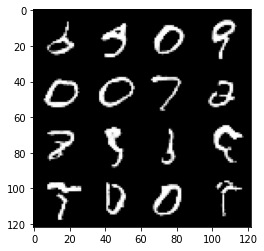

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


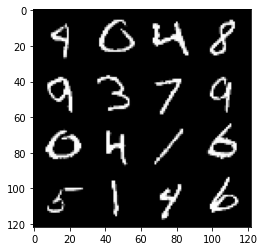

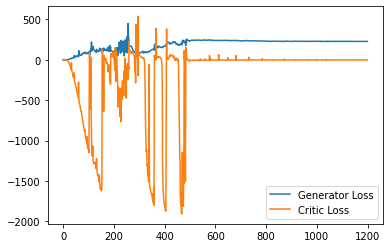

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 25000: Generator loss: 227.84689540100098, critic loss: -0.4930021385500825


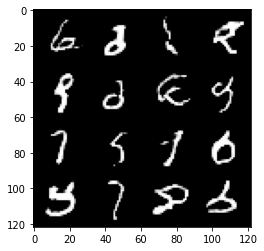

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


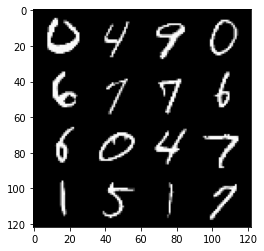

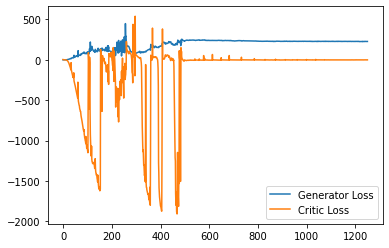

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 26000: Generator loss: 227.44040591430664, critic loss: -0.565148271270096


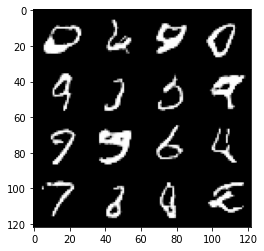

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


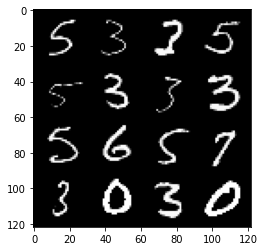

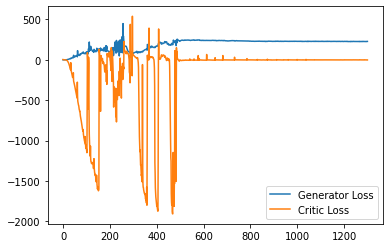

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 27000: Generator loss: 226.61913807678224, critic loss: -0.5061237693876024


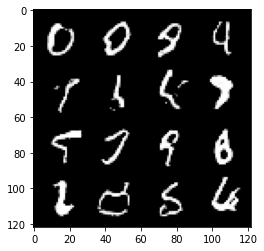

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


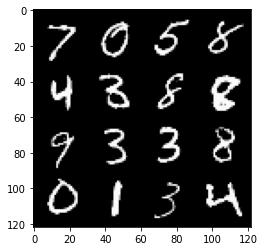

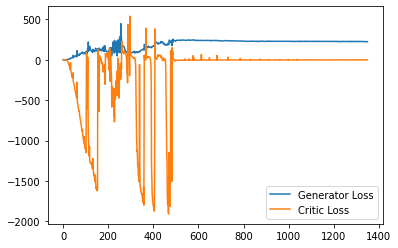

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 28000: Generator loss: 225.26915397644044, critic loss: -0.42883549670750876


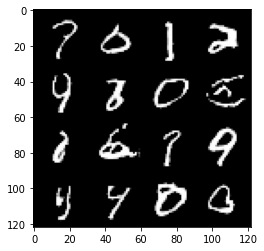

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


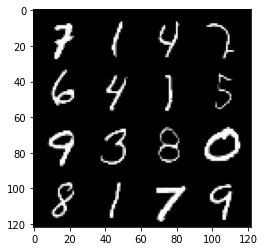

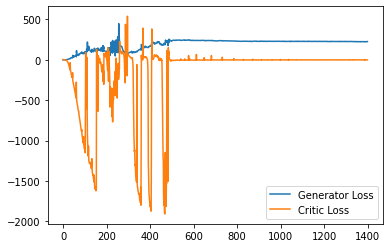

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 29000: Generator loss: 224.84986589050294, critic loss: -0.5253915126559631


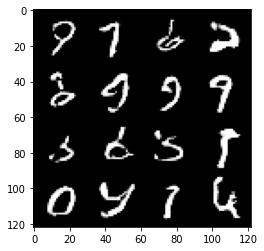

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


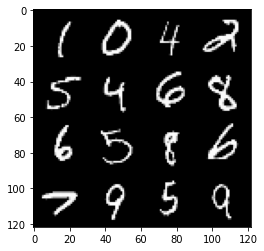

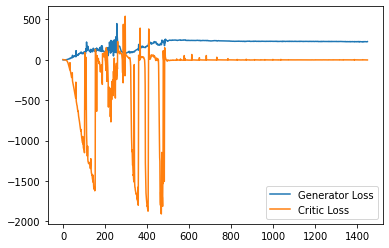

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30000: Generator loss: 224.51400828552246, critic loss: -0.5048909709900615


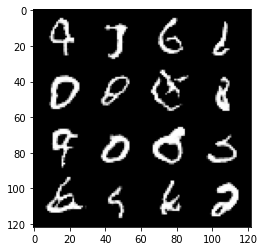

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


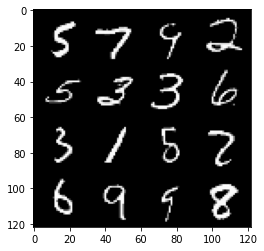

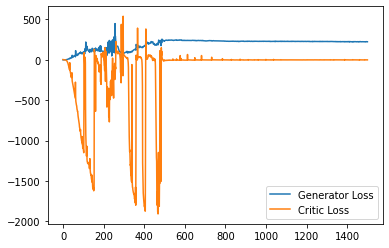

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 31000: Generator loss: 224.60044763183595, critic loss: -0.5640735061268016


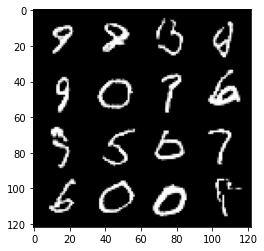

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


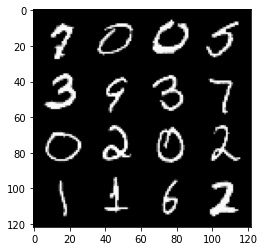

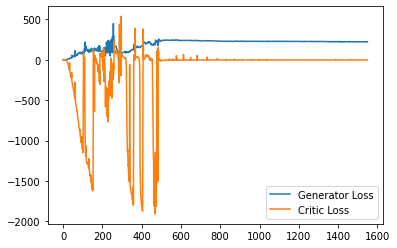

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 32000: Generator loss: 225.00327365112304, critic loss: -0.5323798947110777


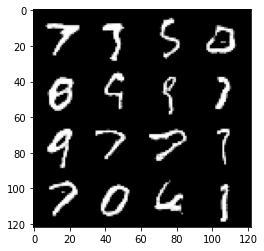

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


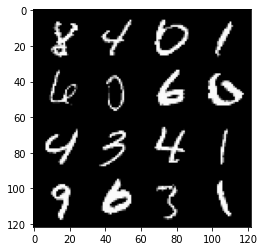

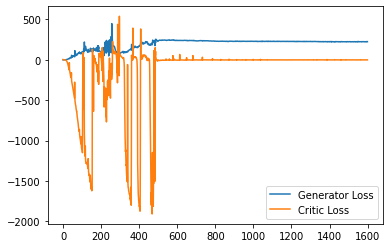

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 33000: Generator loss: 224.97912155151369, critic loss: -0.4301013608388608


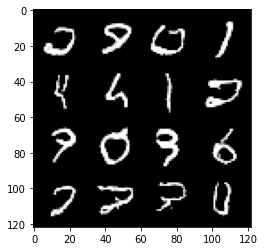

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


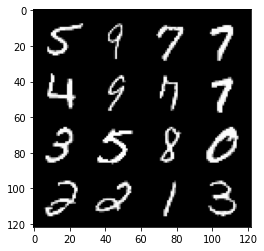

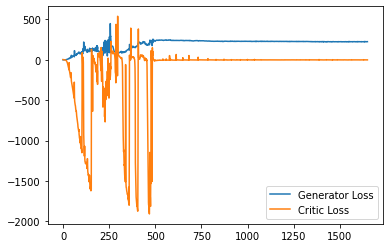

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 34000: Generator loss: 224.736847076416, critic loss: -0.5245180412009356


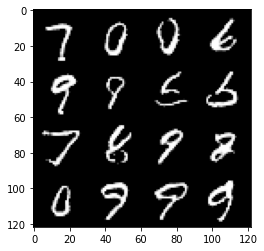

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


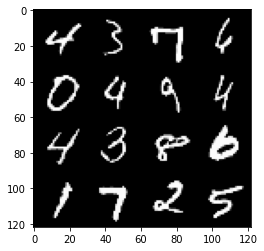

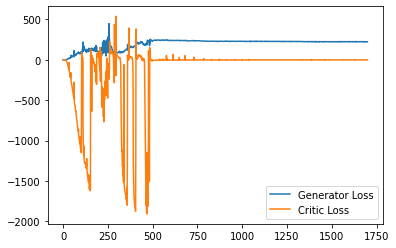

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 35000: Generator loss: 224.88345523071288, critic loss: -0.3828887907527385


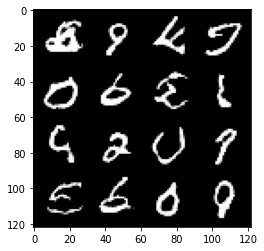

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


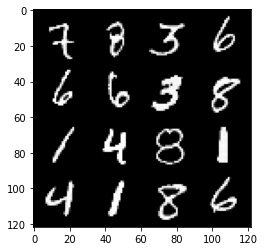

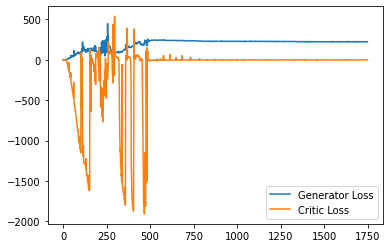

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 36000: Generator loss: 225.52120085144043, critic loss: -0.4205248556720714


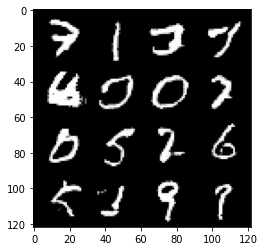

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


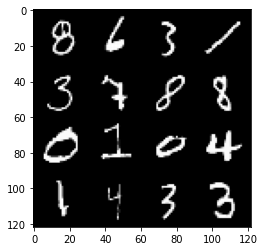

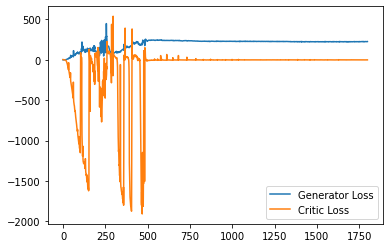

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 37000: Generator loss: 225.77460443115234, critic loss: -0.5250462568414705


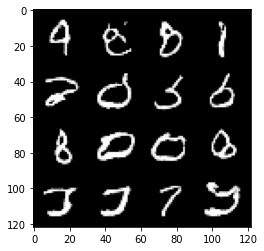

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


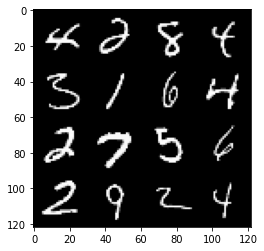

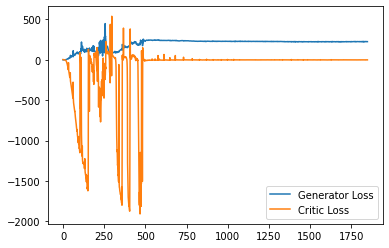

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 38000: Generator loss: 225.71399711608888, critic loss: -0.39854923403263115


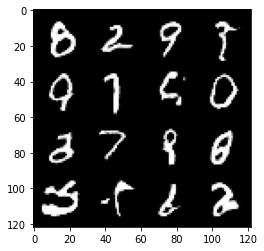

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


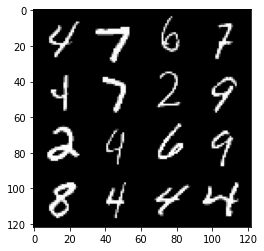

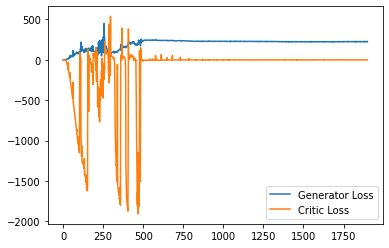

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 39000: Generator loss: 226.06078276062013, critic loss: -0.3003794245844085


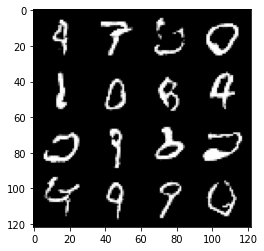

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


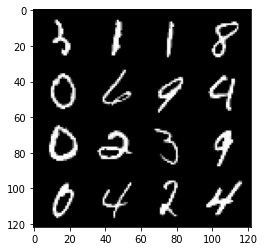

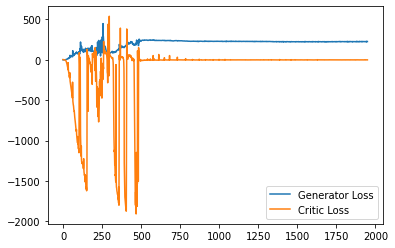

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40000: Generator loss: 226.64003387451172, critic loss: -0.3763867710195484


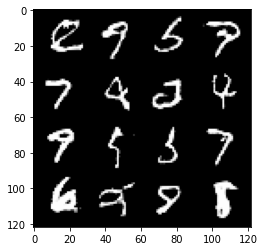

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


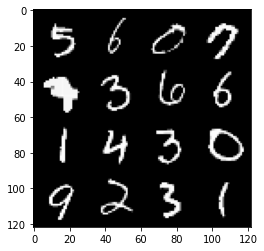

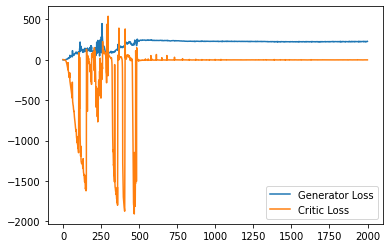

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 41000: Generator loss: 226.6362911682129, critic loss: -0.48900721649825535


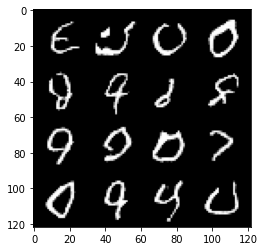

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


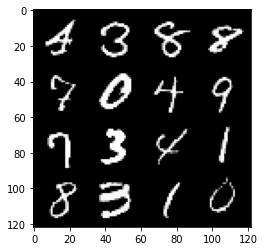

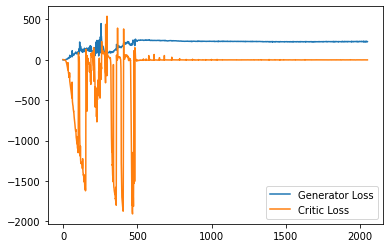

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 42000: Generator loss: 226.37985415649413, critic loss: -0.2976531309783458


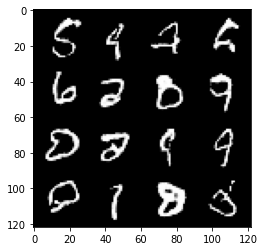

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


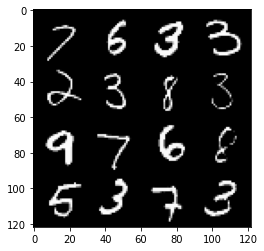

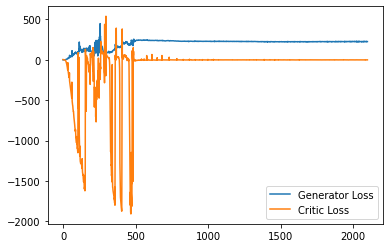

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 43000: Generator loss: 226.45807745361327, critic loss: -0.5173222784847024


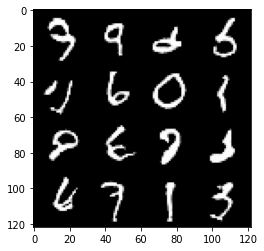

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


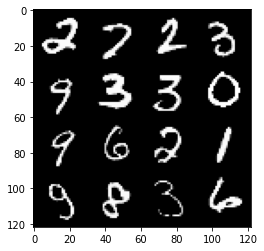

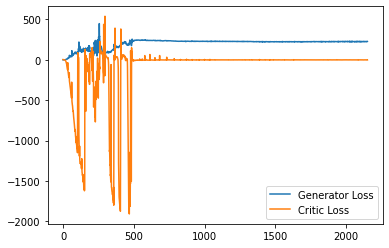

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 44000: Generator loss: 226.5846372833252, critic loss: -0.3919747258760036


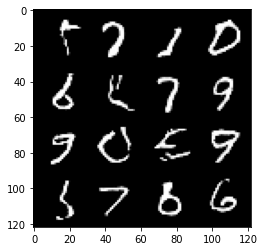

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


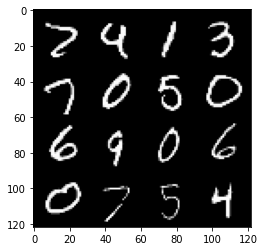

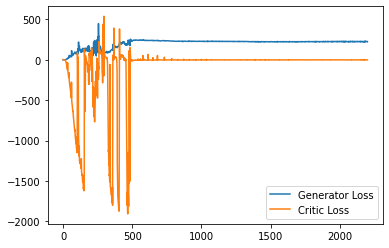

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 45000: Generator loss: 226.8737014312744, critic loss: -0.4184454639578858


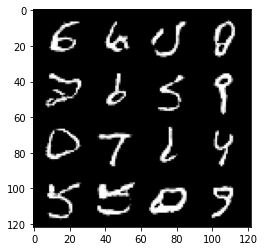

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


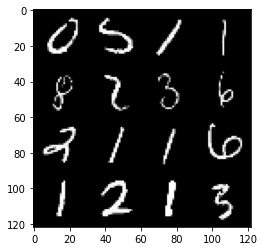

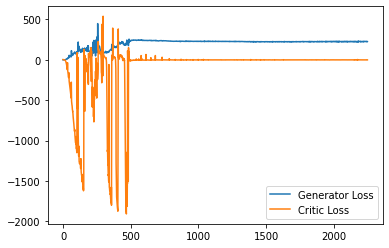

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 46000: Generator loss: 227.089893951416, critic loss: -0.3714822374669215


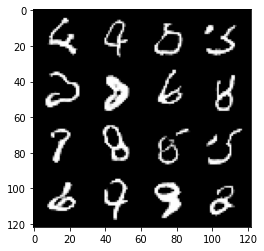

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


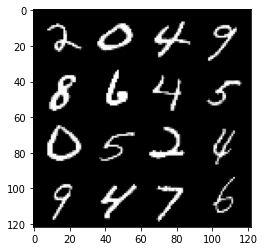

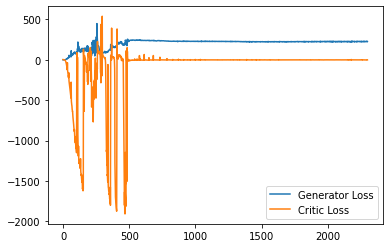

In [13]:
cur_step = 0
generator_losses = []
critic_losses = []


for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):

        cur_batch_size = len(real)
        real = real.to(device)
        mean_iteration_critic_loss = 0

        ### Update critic ###
        for _ in range(crit_repeats):

            crit_opt.zero_grad()
            fake_noise = gen.get_noise(cur_batch_size, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = gen.get_noise(cur_batch_size, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1